In [1]:
#pip install imageio

In [1]:
##This is a framework of patch-based hyperspectral classification
import os
import time
import random
import spectral
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.patches as mpts
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from sklearn.preprocessing import minmax_scale
from scipy.io import loadmat
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
##hypeperameters and experimental settings
RANDOM_SEED=666
MODEL_NAME = '3DConvKAN' ## your model name
DATASET = 'Tangdaowan'  ## PU  IP  SA or your personal dataset
TRAIN_RATE = 0.3  ## ratio of training data
VAL_RATE = 0.2    ## ratio of valuating data
EPOCH = 5    ##number of epoch
VAL_EPOCH = 1  ##interval of valuation
LR = 0.001    ##learning rate
WEIGHT_DECAY = 1e-6  
BATCH_SIZE = 64
DEVICE = 0  ##-1:CPU  0:cuda 0
N_PCA = 15  ## reserved PCA components   0:use origin data
NORM = True  ## normalization or not
PATCH_SIZE = 8 ## patchsize of input 3D cube   1:only spectral sequence
CHECK_POINT = None  ## path of check point model

SAVE_PATH = f"E:/Roy/Sim Pool/Results\\{MODEL_NAME}\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [3]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def loadData(name): ## customize data and return data label and class_name
    data_path = os.path.join(os.getcwd(),'E:/Roy/Sim Pool/Data/')
    if name == 'Tangdaowan':
        data = loadmat(os.path.join(data_path, 'QUH-Tangdaowan.mat'))['Tangdaowan']
        labels = loadmat(os.path.join(data_path, 'QUH-Tangdaowan_GT.mat'))['TangdaowanGT']
        class_name = [     "Rubber track",    "Flaggingv",    "Sandy",    "Asphalt",    "Boardwalk",    "Rocky shallows",    "Grassland",
    "Bulrush",    "Gravel road",    "Ligustrum vicaryi",    "Coniferous pine",    "Spiraea",    "Bare soil",    "Buxus sinica",    "Photinia serrulata",
    "Populus",    "Ulmus pumila L",    "Seawater"]
    
    elif name == 'Qingyun':
        data = loadmat(os.path.join(data_path, 'QUH-Qingyun.mat'))['Chengqu']
        labels = loadmat(os.path.join(data_path, 'QUH-Qingyun_GT.mat'))['ChengquGT']
        class_name = ["Trees", "Concrete building", "Car", "Ironhide building", "Plastic playground", "Asphalt road"]
    
    elif name == 'Pingan':
        data = loadmat(os.path.join(data_path, 'QUH-Pingan.mat'))['Haigang']
        labels = loadmat(os.path.join(data_path, 'QUH-Pingan_GT.mat'))['HaigangGT']
        class_name = ["Ship", "Seawater", "Trees"," Concrete structure building", "Floating pier", "Brick houses", 
                      "Steel houses"," Wharf construction land", "Car", "Road"]
    return data, labels, class_name


In [5]:
data,label,class_name = loadData(DATASET)
NUM_CLASS = label.max()

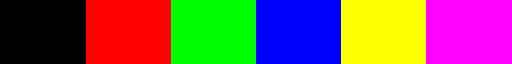

In [6]:
a = data[:,:,[1,2,3]]
cmap=plt.matplotlib.colors.ListedColormap(spectral.spy_colors/255,'Classification',6)
cmap

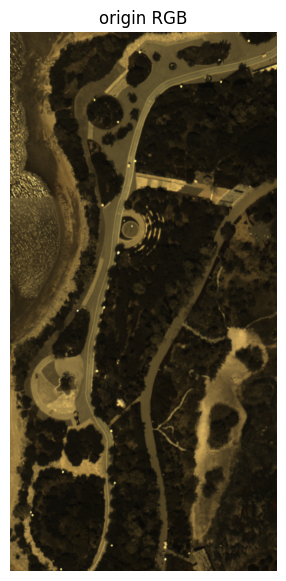

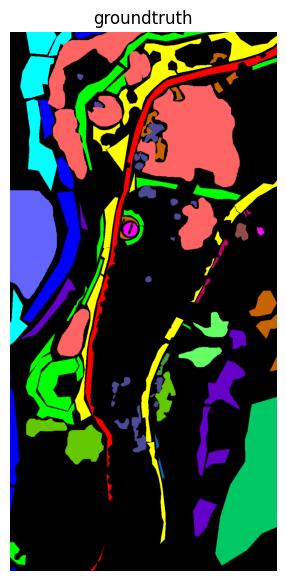

In [7]:
def img_display(data = None, rgb_band = None, classes = None,class_name = None,title = None, 
                figsize = (7,7),palette = spectral.spy_colors):
    if data is not None:
        im_rgb = np.zeros_like(data[:,:,0:3])
        im_rgb = data[:,:,rgb_band]
        im_rgb = im_rgb/(np.max(np.max(im_rgb,axis = 1),axis = 0))*255
        im_rgb = np.asarray(im_rgb,np.uint8)
        fig, rgbax = plt.subplots(figsize = figsize)
        rgbax.imshow(im_rgb)
        rgbax.set_title(title)
        rgbax.axis('off')
        
    elif classes is not None:
        rgb_class = np.zeros((classes.shape[0],classes.shape[1],3))
        for i in np.unique(classes):
            rgb_class[classes==i]=palette[i]
        rgb_class = np.asarray(rgb_class, np.uint8)
        _,classax = plt.subplots(figsize = figsize)
        classax.imshow(rgb_class)
        classax.set_title(title)
        classax.axis('off')
        # rect = [mpts.Rectangle((0,0),1,1,facecolor=palette[i]/255) for i in range(len(class_name))]
        # classax.legend(rect,class_name,bbox_to_anchor = (1.04,1),frameon=False,loc = 'upper left')
        
img_display(data,(30,20,10),title='origin RGB')
img_display(classes=label,title='groundtruth',class_name=class_name)

In [8]:
# ## display HSI
# rgb_view=spectral.imshow(data,(30,20,10),classes=label.astype(int),title='RGB origin',figsize=(7,7))
# gt_view = spectral.imshow(classes=label.astype(int), title='GroundTruth',figsize=(7,7))
# view = spectral.imshow(data,(30,20,10),classes=label.astype(int),figsize=(7,7))
# view.set_display_mode('overlay')
# view.set_title('Overlay')
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_RGB_origin.jpg',data,(30,20,10))
spectral.save_rgb(f'E:/Roy/Sim Pool/Results/{DATASET}_gt.jpg',label,colors = spectral.spy_colors)

In [9]:
def applyPCA(X, numComponents=15, norm = True):
    """PCA and processing
    Args:
        X (ndarray M*N*C): data needs DR
        numComponents (int, optional):  number of reserved components(Defaults to 15, 0 for no PCA).
        norm: normalization or not
    Returns:
        newX: processed data
        pca: 
    """
    
    if numComponents == 0:
        newX = np.reshape(X, (-1, X.shape[2]))
    else:
        newX = np.reshape(X, (-1, X.shape[2]))
        pca = PCA(n_components=numComponents)   ##PCA and normalization
        newX = pca.fit_transform(newX)
    if norm:
        newX = minmax_scale(newX, axis=1)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], -1))
    return newX, newX.shape[2]

In [10]:
data,N_PCA = applyPCA(data, N_PCA, NORM)
data.shape,N_PCA

((1740, 860, 15), 15)

In [11]:
def sample_gt(gt, train_rate):
    """ generate training gt for training dataset
    Args:
        gt (ndarray): full classmap
        train_rate (float): ratio of training dataset
    Returns:
        train_gt(ndarray): classmap of training data
        test_gt(ndarray): classmap of test data
    """
    indices = np.nonzero(gt)  ##([x1,x2,...],[y1,y2,...])
    X = list(zip(*indices))  ## X=[(x1,y1),(x2,y2),...] location of pixels
    y = gt[indices].ravel()
    train_gt = np.zeros_like(gt)
    test_gt = np.zeros_like(gt)
    if train_rate > 1:
       train_rate = int(train_rate)
    train_indices, test_indices = train_test_split(X, train_size=train_rate, stratify=y, random_state=100)
    train_indices = [t for t in zip(*train_indices)]   ##[[x1,x2,...],[y1,y2,...]]
    test_indices = [t for t in zip(*test_indices)]
    train_gt[tuple(train_indices)] = gt[tuple(train_indices)]
    test_gt[tuple(test_indices)] = gt[tuple(test_indices)]
    
    return train_gt, test_gt

In [12]:
train_gt, test_gt = sample_gt(label,TRAIN_RATE)
val_gt,test_gt = sample_gt(test_gt,VAL_RATE/(1-TRAIN_RATE))

          class          train_num  val_num   test_num   total   
      Rubber track          7755      5170     12924     25849   
        Flaggingv          16666     11111     27776     55553   
          Sandy            10211      6807     17019     34037   
         Asphalt           18207     12138     30345     60690   
        Boardwalk           559       372       931       1862   
     Rocky shallows        11137      7425     18563     37125   
        Grassland           4238      2825      7064     14127   
         Bulrush           19226     12817     32044     64087   
       Gravel road          9208      6139     15348     30695   
    Ligustrum vicaryi       535       357       891       1783   
     Coniferous pine        6371      4247     10618     21236   
         Spiraea            225       150       374       749    
        Bare soil           506       337       843       1686   
      Buxus sinica          266       177       443       886    
   Photini

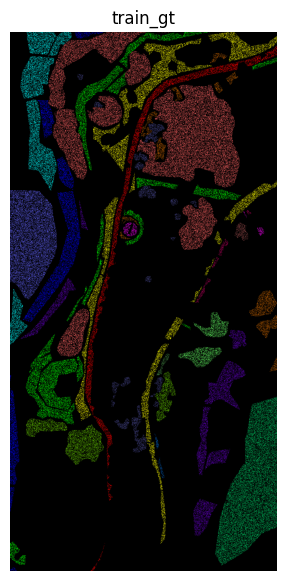

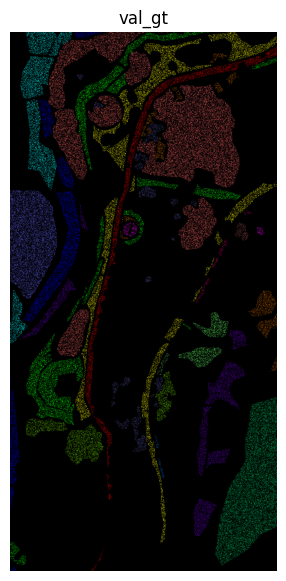

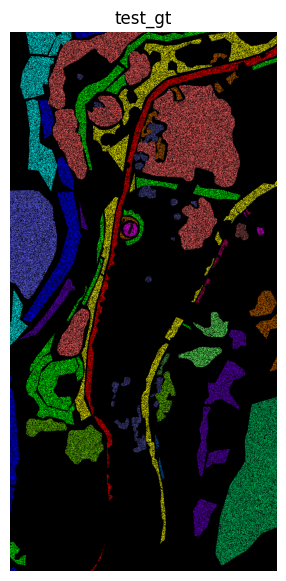

In [13]:
## display sampling info
sample_report = f"{'class': ^25}{'train_num':^10}{'val_num': ^10}{'test_num': ^10}{'total': ^10}\n"
for i in np.unique(label):
    if i == 0: continue
    sample_report += f"{class_name[i-1]: ^25}{(train_gt==i).sum(): ^10}{(val_gt==i).sum(): ^10}{(test_gt==i).sum(): ^10}{(label==i).sum(): ^10}\n"
sample_report += f"{'total': ^25}{np.count_nonzero(train_gt): ^10}{np.count_nonzero(val_gt): ^10}{np.count_nonzero(test_gt): ^10}{np.count_nonzero(label): ^10}"
print(sample_report)
img_display(classes=train_gt,title='train_gt')
img_display(classes=val_gt,title='val_gt')
img_display(classes=test_gt,title='test_gt')

# spectral.imshow(classes=train_gt, title='train_gt')
# spectral.imshow(classes=val_gt, title='val_gt')
# spectral.imshow(classes=test_gt, title='test_gt')

In [14]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 
        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        data = torch.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label


In [15]:
##create dataset and dataloader
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, label, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [16]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([15, 8, 8, 1]), tensor(9))

In [17]:
#pip install unfoldNd

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from fast_kan import FastKAN as KAN


In [19]:
in_chs=15
patch_size=8
n_h=64

class Net(nn.Module):
    # Define the architecture of the network
    def __init__(self):
        super(Net, self).__init__()
        
        self.in_chs = in_chs
        self.patch_size = patch_size
        self.n_h = n_h
        
        self.KAN1 = KAN([in_chs * patch_size * patch_size, n_h, NUM_CLASS])

    # Set the flow of data through the network for the forward pass
    # x represents the data
    def forward(self, x):
        # F.relu is the rectified-linear activation function
        x = torch.flatten(x, 1)
        x = self.KAN1(x)

        output = F.log_softmax(x, dim=1)
        
        return output

In [20]:
#instantiate CNN model
model= Net()
model

Net(
  (KAN1): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((960,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=7680, out_features=64, bias=False)
        (base_linear): Linear(in_features=960, out_features=64, bias=True)
      )
      (1): FastKANLayer(
        (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=512, out_features=18, bias=False)
        (base_linear): Linear(in_features=64, out_features=18, bias=True)
      )
    )
  )
)

In [21]:
torch.cuda.is_available()

True

In [22]:
from torchsummary import summary
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
summary(model.to(device),(15, 8,8,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1                  [-1, 960]           1,920
RadialBasisFunction-2               [-1, 960, 8]               0
      SplineLinear-3                   [-1, 64]         491,520
            Linear-4                   [-1, 64]          61,504
      FastKANLayer-5                   [-1, 64]               0
         LayerNorm-6                   [-1, 64]             128
RadialBasisFunction-7                [-1, 64, 8]               0
      SplineLinear-8                   [-1, 18]           9,216
            Linear-9                   [-1, 18]           1,170
     FastKANLayer-10                   [-1, 18]               0
          FastKAN-11                   [-1, 18]               0
Total params: 565,458
Trainable params: 565,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forwar

In [22]:
#PATH = 'E:/Roy/Sim Pool/Results/Training/3D2DConvKAN_Tangdaowan_30.pth'
#model.load_state_dict(torch.load(PATH))
#moel=torch.load(PATH)

In [23]:
EPOCH=100


## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')

loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []
epoch_start = 0

model = model ##modify to you model 
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)


if CHECK_POINT is not None:
    
    model_ckpt = torch.load(CHECK_POINT,map_location = device)
    model.load_state_dict(model_ckpt['state_dict'])
    epoch_start = model_ckpt['epoch']
    optimizer.load_state_dict(model_ckpt['optimizer'])
    loss_list = model_ckpt['loss_list']
    acc_list = model_ckpt['acc_list']
    val_acc_list = model_ckpt['val_acc_list']
    val_epoch_list = model_ckpt['val_epoch_list']

loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()
train_st = time.time()
run_error = False

try:
    for e in tqdm(range(epoch_start,EPOCH), desc="Training:"):
        
        model.train()
        avg_loss = 0.
        train_acc = 0
        
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            
            data,target = data.view(-1, 15 * 8 * 8).to(device),target.to(device)
            
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            
            val_acc =0
            model.eval()
            
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                
                data,target = data.view(-1, 15 * 8 * 8).to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            save_dict = {'state_dict':model.state_dict(), 'epoch':e+1, 'optimizer': optimizer.state_dict(),
                        'loss_list':loss_list, 'acc_list': acc_list, 'val_acc_list': val_acc_list, 'val_epoch_list':val_epoch_list}
            torch.save(save_dict,save_name)
except Exception as exc:
    print(exc)
    run_error = True
finally: 
    print(f'Stop in epoch {e}')
train_time = time.time()-train_st
print(f"training time: {train_time}")

Training::   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 0/100 loss:0.005635271693242528  acc:0.8773570800614799


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 0/100  val_acc:0.9163564271168804


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 1/100 loss:0.003404785933289827  acc:0.9207219707073184


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 1/100  val_acc:0.9286463986795008


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 2/100 loss:0.002721456143279002  acc:0.9363850031995885


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 2/100  val_acc:0.9409363702421214


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 3/100 loss:0.0022944668649831144  acc:0.9459478855803216


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 3/100  val_acc:0.9436545172373579


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 4/100 loss:0.001958743953849257  acc:0.9536627813096185


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 4/100  val_acc:0.9487140383770061


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 5/100 loss:0.0017351560647369862  acc:0.958357504679772


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 5/100  val_acc:0.9479515218931939


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 6/100 loss:0.0015629640226243215  acc:0.9628249675555741


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 6/100  val_acc:0.9517013088371175


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 7/100 loss:0.0014090915834948756  acc:0.9664910381618215


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 7/100  val_acc:0.9488665416737685


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 8/100 loss:0.001247163260700998  acc:0.970049459060218


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 8/100  val_acc:0.962834049500776


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 9/100 loss:0.0011316717047186184  acc:0.9727646239137846


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 9/100  val_acc:0.954616813039929


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 10/100 loss:0.0010568297162687117  acc:0.974989384542698


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 10/100  val_acc:0.959981340773102


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 11/100 loss:0.0009766931354990953  acc:0.976616091239108


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 11/100  val_acc:0.9610488638504391


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 12/100 loss:0.0009002452681339089  acc:0.9781291676883421


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 12/100  val_acc:0.9659917648219748


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 13/100 loss:0.0008612590733951738  acc:0.9794508668791752


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 13/100  val_acc:0.9680191615906991


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 14/100 loss:0.0007839928543126949  acc:0.9815141529463127


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 14/100  val_acc:0.9647537968835502


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 15/100 loss:0.0007477287351793033  acc:0.9822796619799173


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 15/100  val_acc:0.9649960080019377


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 16/100 loss:0.0007276812752552103  acc:0.982716241350645


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 16/100  val_acc:0.9649780664376127


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 17/100 loss:0.0006816432937282503  acc:0.9843309869684048


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 17/100  val_acc:0.9686381455599113


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 18/100 loss:0.0006529233414717144  acc:0.9848333522717079


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 18/100  val_acc:0.9647896800122002


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 19/100 loss:0.0006365180744231045  acc:0.9851503208559348


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 19/100  val_acc:0.9672297327603994


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 20/100 loss:0.0005859919773097801  acc:0.9861012266086155


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 20/100  val_acc:0.9592098535071273


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 21/100 loss:0.0005838458141516437  acc:0.9862208373951163


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 21/100  val_acc:0.9712665847335229


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 22/100 loss:0.0005739875339540675  acc:0.986657416765844


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 22/100  val_acc:0.9677679796901492


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 23/100 loss:0.0005360195932980008  acc:0.9876800889904251


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 23/100  val_acc:0.9730876535125098


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 24/100 loss:0.0005168892564161955  acc:0.9880269602712772


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 24/100  val_acc:0.9669606092955245


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 25/100 loss:0.0005049187086815659  acc:0.9881346099791279


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 25/100  val_acc:0.9696069900334611


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 26/100 loss:0.0004842316059879154  acc:0.9890197297992332


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 26/100  val_acc:0.9704233312102483


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 27/100 loss:0.00052543412726032  acc:0.9878894078668015


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 27/100  val_acc:0.9685663793026114


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 28/100 loss:0.00044732178530902477  acc:0.9897553361362128


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 28/100  val_acc:0.9688085904209988


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 29/100 loss:0.00045465669065188714  acc:0.9895101340238863


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 29/100  val_acc:0.9714639419410979


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 30/100 loss:0.0004378527090645675  acc:0.9900723047204397


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 30/100  val_acc:0.9732401568092722


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 31/100 loss:0.00045492525013419766  acc:0.9894323870126608


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 31/100  val_acc:0.9706745131107981


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 32/100 loss:0.00042539781247929906  acc:0.9904072149226417


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 32/100  val_acc:0.968270343491249


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 33/100 loss:0.0004242475400174145  acc:0.9903175068327662


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 33/100  val_acc:0.9699119966269859


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 34/100 loss:0.000416334010957568  acc:0.9905507478664426


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 34/100  val_acc:0.9744870955298592


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 35/100 loss:0.00038335038251187875  acc:0.9910889964056959


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 35/100  val_acc:0.9759044791115338


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 36/100 loss:0.00040578620493034314  acc:0.9905985921810428


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 36/100  val_acc:0.9728723547406098


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 37/100 loss:0.000400469766107784  acc:0.9912265488101717


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 37/100  val_acc:0.9675078270074368


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 38/100 loss:0.0003706887471552857  acc:0.9915614590123737


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 38/100  val_acc:0.9676603303041992


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 39/100 loss:0.0003796865953126155  acc:0.9911547823382713


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 39/100  val_acc:0.9674270899679743


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 40/100 loss:0.0003887062649121144  acc:0.9910830158663708


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 40/100  val_acc:0.9759941869331586


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 41/100 loss:0.00035596070832884295  acc:0.9919561746078261


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 41/100  val_acc:0.9750701963704216


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 42/100 loss:0.0003533514780236126  acc:0.9919920578437763


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 42/100  val_acc:0.9743256214509343


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 43/100 loss:0.00035488253268470694  acc:0.9918186222033503


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 43/100  val_acc:0.9739757609465969


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 44/100 loss:0.0003520901659341979  acc:0.9919681356864762


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 44/100  val_acc:0.9731235366411597


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 45/100 loss:0.0003321887623437623  acc:0.9925602090796548


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 45/100  val_acc:0.9729710333443973


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 46/100 loss:0.00034450389160874356  acc:0.9926678587875054


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 46/100  val_acc:0.9730158872552098


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 47/100 loss:0.0003627471588935753  acc:0.9919023497539008


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 47/100  val_acc:0.9679832784620491


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 48/100 loss:0.000365201890539043  acc:0.9919860773044513


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 48/100  val_acc:0.9741731181541718


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 49/100 loss:0.0003207733839856379  acc:0.992745605798731


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 49/100  val_acc:0.9721905752962601


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 50/100 loss:0.0003410195363481678  acc:0.9923867734392288


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 50/100  val_acc:0.9722354292070725


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 51/100 loss:0.0003024551369785889  acc:0.9931762046301336


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 51/100  val_acc:0.9701990616561859


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 52/100 loss:0.00031936101629419553  acc:0.9928293333492815


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 52/100  val_acc:0.9725673481470849


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 53/100 loss:0.0003178884778400746  acc:0.9927814890346811


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 53/100  val_acc:0.9705130390318731


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 54/100 loss:0.00029724036697873645  acc:0.9933197375739344


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 54/100  val_acc:0.9769271482780584


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 55/100 loss:0.00032518145472911175  acc:0.9926379560908802


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 55/100  val_acc:0.9698492011518485


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 56/100 loss:0.00029990947303315996  acc:0.993427387281785


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 56/100  val_acc:0.9649152709624752


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 57/100 loss:0.0003078218673984221  acc:0.9932360100233839


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 57/100  val_acc:0.9748369560341966


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 58/100 loss:0.00031455525365368773  acc:0.9932180684054088


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 58/100  val_acc:0.9740654687682219


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 59/100 loss:0.00027326560341868803  acc:0.9938221028772375


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 59/100  val_acc:0.9753752029639464


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 60/100 loss:0.0003222590880066038  acc:0.9926080533942551


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 60/100  val_acc:0.9697325809837359


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 61/100 loss:0.0003078584430419771  acc:0.9929549246751072


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 61/100  val_acc:0.9730697119481848


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 62/100 loss:0.0002911410286915971  acc:0.9934513094390852


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 62/100  val_acc:0.9734285432346846


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 63/100 loss:0.0002671010201442043  acc:0.9938759277311628


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 63/100  val_acc:0.9720111596530101


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 64/100 loss:0.00029803749970743864  acc:0.9933436597312345


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 64/100  val_acc:0.9752854951423214


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 65/100 loss:0.00027907524165865814  acc:0.993738375326687


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 65/100  val_acc:0.9769361190602208


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 66/100 loss:0.00029501055753796324  acc:0.9933436597312345


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 66/100  val_acc:0.9757699173790962


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 67/100 loss:0.0002675051771220652  acc:0.9939476942030633


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 67/100  val_acc:0.9694096328258861


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 68/100 loss:0.00026914800015720723  acc:0.9939656358210384


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 68/100  val_acc:0.976433755259121


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 69/100 loss:0.00027904676457906474  acc:0.9937742585626371


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 69/100  val_acc:0.9769092067137334


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 70/100 loss:0.00030703513773149737  acc:0.9932001267874337


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 70/100  val_acc:0.973957819382272


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 71/100 loss:0.00027544535890463646  acc:0.9937144531693868


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 71/100  val_acc:0.9735900173136096


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 72/100 loss:0.0002683610691731062  acc:0.9941151493041642


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 72/100  val_acc:0.9728275008297973


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 73/100 loss:0.00028458024406264514  acc:0.9938759277311628


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 73/100  val_acc:0.9750163716774466


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 74/100 loss:0.00024845737621851614  acc:0.9944321178883911


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 74/100  val_acc:0.9765324338629086


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 75/100 loss:0.00028865744488132394  acc:0.993750336405337


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 75/100  val_acc:0.9715626205448853


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 76/100 loss:0.0002595731099405958  acc:0.9941570130794395


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 76/100  val_acc:0.975097108716909


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 77/100 loss:0.00027100727587283616  acc:0.9940493633715889


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 77/100  val_acc:0.976469638387771


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 78/100 loss:0.0002724329646103344  acc:0.9939775968996885


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 78/100  val_acc:0.9751778457563715


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 79/100 loss:0.00027582951747060814  acc:0.993905830427788


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 79/100  val_acc:0.9715805621092103


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 80/100 loss:0.0002515113492289952  acc:0.9941869157760647


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 80/100  val_acc:0.9757878589434212


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 81/100 loss:0.00024524945360734955  acc:0.9945636897535419


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 81/100  val_acc:0.9766400832488584


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 82/100 loss:0.00028357442011731635  acc:0.9937264142480369


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 82/100  val_acc:0.9729082378692598


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 83/100 loss:0.00025599260264077433  acc:0.9944261373490662


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 83/100  val_acc:0.9719483641778727


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 84/100 loss:0.00025424307398940404  acc:0.9944979038209666


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 84/100  val_acc:0.9744960663120218


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 85/100 loss:0.00025300941382190817  acc:0.9945577092142169


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 85/100  val_acc:0.9755815309536838


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 86/100 loss:0.0002525852897804974  acc:0.994396234652441


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 86/100  val_acc:0.9705848052891731


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 87/100 loss:0.00027374284698804903  acc:0.994396234652441


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 87/100  val_acc:0.9755546186071964


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 88/100 loss:0.00026575179742250763  acc:0.9941928963153898


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 88/100  val_acc:0.9699030258448235


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 89/100 loss:0.0002592998181843941  acc:0.9944620205850163


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 89/100  val_acc:0.9744960663120218


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 90/100 loss:0.00022504757083188087  acc:0.9951677242253707


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 90/100  val_acc:0.9773308334753708


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 91/100 loss:0.00027042421539572986  acc:0.9943184876412154


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 91/100  val_acc:0.976649054031021


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 92/100 loss:0.00022737704930029363  acc:0.9949823275062946


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 92/100  val_acc:0.9728364716119599


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 93/100 loss:0.00025810211755653435  acc:0.9943005460232404


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 93/100  val_acc:0.9767477326348084


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 94/100 loss:0.00023291774564578773  acc:0.9947789891692432


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 94/100  val_acc:0.9696069900334611


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 95/100 loss:0.00024466969892810684  acc:0.9947550670119432


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 95/100  val_acc:0.9704412727745733


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 96/100 loss:0.0002432305831467932  acc:0.9947431059332931


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 96/100  val_acc:0.9731055950768347


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 97/100 loss:0.0002490496002902066  acc:0.9944141762704161


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 97/100  val_acc:0.9728095592654723


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 98/100 loss:0.00025835422586834787  acc:0.9944261373490662


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 98/100  val_acc:0.9726570559687099


  0%|          | 0/2613 [00:00<?, ?it/s]

epoch 99/100 loss:0.00023553939982214338  acc:0.9948686972591189


  0%|          | 0/1742 [00:00<?, ?it/s]

epoch 99/100  val_acc:0.9711589353475729
Stop in epoch 99
training time: 3050.4552614688873


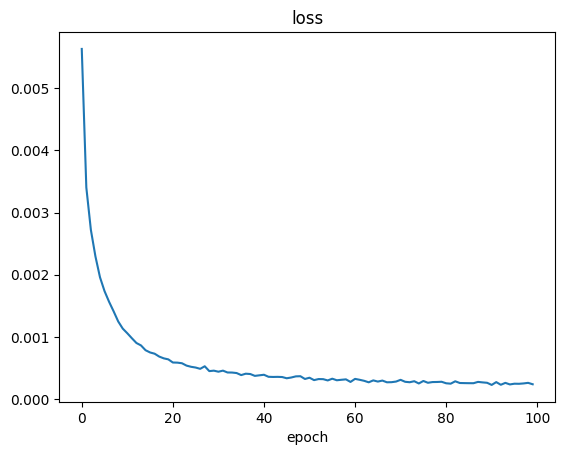

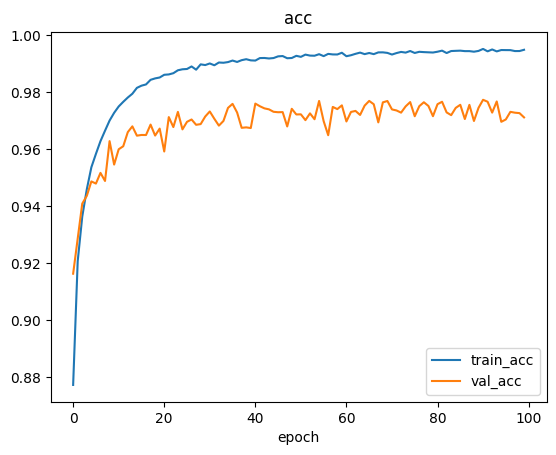

In [24]:
##display loss and acc
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax2 = fig2.add_subplot(1,1,1)
ax1.plot(np.arange(e+1),loss_list)
ax1.set_title('loss')
ax1.set_xlabel('epoch')
ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
ax2.set_title('acc')
ax2.set_xlabel('epoch')
ax2.legend()

In [25]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path, del_others = True):
    """get best model path by valuation list
    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir
    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    if del_others:
        for f in os.listdir(save_path):
            if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
                os.remove(os.path.join(save_path,f))
    return best_model_path

In [26]:
# save
PATH = 'E:/Roy/Sim Pool/Results/Training/1DKAN_Tangdaowan_30.pth'
torch.save(model.state_dict(), PATH)
# reload


best model:epoch_90_acc_0.9773.pth


  0%|          | 0/23382 [00:00<?, ?it/s]

inferring time: 69.31085515022278


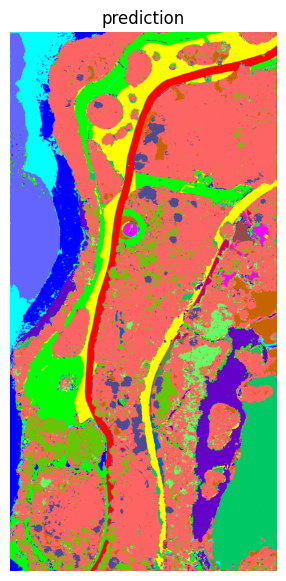

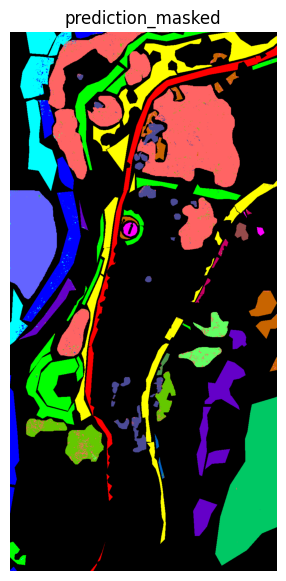

In [27]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH, not run_error)

best_model = model  ## modify to your model

best_model.load_state_dict(torch.load(best_model_path)['state_dict'])
## inference
best_model
best_model.eval()
pred_map = []
infer_st = time.time()

for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
infer_time = time.time() - infer_st


print(f"inferring time: {infer_time}")
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(label.shape[0],label.shape[1])
img_display(classes=pred_map,title='prediction',figsize=(7,7))
img_display(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
# spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
# spectral.imshow(classes=pred_map*(label!=0),title='prediction_masked',figsize=(7,7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/1DKAN_prediction_Tangdaowan.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"E:/Roy/Sim Pool/Results/1DKAN__prediction_masked_Tangdaowan.jpg"),pred_map*(label!=0),colors = spectral.spy_colors)

In [28]:
## classfication report
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += f"training time: {train_time}\ninferring time: {infer_time}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'E:/Roy/Sim Pool/Results/Training/1DKAN_Tangdaowan_30_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.976808858779119
AA: 0.961417120191499
Kappa: 0.9735817855741575
training time: 3050.4552614688873
inferring time: 69.31085515022278
                    precision    recall  f1-score   support

      Rubber track     0.9997    0.9992    0.9995     12924
         Flaggingv     0.9959    0.9946    0.9952     27776
             Sandy     0.9684    0.9779    0.9731     17019
           Asphalt     0.9985    0.9971    0.9978     30345
         Boardwalk     0.9665    0.9914    0.9788       931
    Rocky shallows     0.9717    0.9725    0.9721     18563
         Grassland     0.9711    0.9078    0.9384      7064
           Bulrush     0.9998    0.9996    0.9997     32044
       Gravel road     0.9950    0.9939    0.9945     15348
 Ligustrum vicaryi     0.9549    0.9495    0.9522       891
   Coniferous pine     0.9039    0.8430    0.8724     10618
           Spiraea     0.9534    0.9305    0.9418       374
         Bare soil     0.9964    0.9976    0.9970       843
      Buxus sinica   